# Recommender System using Collaborative Filtering 

Applied on a Dataset of movie Ratings

###### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize
%matplotlib inline

###### Loading Data 

In [2]:
data = loadmat('ex8_movies.mat')
# data  # contains R and Y array

R = data['R'] # indicator if uer rated movie or not (no of movies x no. of users)
Y = data['Y'] # rating user gave to movie (no of movies x no of users)

Y.shape, R.shape

((1682, 943), (1682, 943))

So, there are 1682 movies in the list and 943 users

In [3]:
Y[1, R[1,:]].mean() # Averaging over 1st row of Y where rating is present

2.5832449628844114

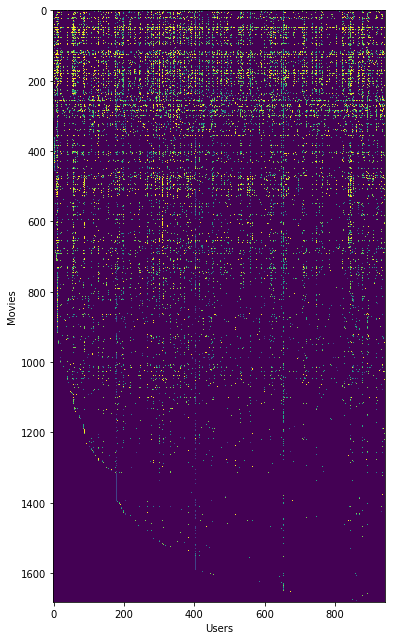

In [4]:
fig, ax = plt.subplots(figsize=(9,9))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

###### Defining Cost Function 

In [5]:
def cost(params, Y, R, numOfFeatures, rate):
    Y = np.matrix(Y) # 1682, 943
    R = np.matrix(R) # 1682, 943
    numOfMovies = Y.shape[0]
    numOfUsers = Y.shape[1]
    
    # Reshaping paramaters to matrices, as we get unrolled ones so as to be used by inbuild scipy optimization fxn
    X = np.matrix(np.reshape(params[: numOfMovies*numOfFeatures], (numOfMovies, numOfFeatures))) # 1682, 10
    theta = np.matrix(np.reshape(params[numOfMovies*numOfFeatures:], (numOfUsers, numOfFeatures))) # 943, 10
    
    J=0
    Xgrad = np.zeros(X.shape) # 1682, 10
    thetagrad = np.zeros(theta.shape) # 943, 10
    
    # Compute the Cost
    error = np.multiply((X * theta.T) - Y, R) # 1682, 943
    sqError = np.power(error, 2)
    
    J = (1. /2)*np.sum(sqError)
    
    # Added Regularization
    J += ((rate / 2) * np.sum(np.power(theta, 2)))
    J += ((rate / 2) * np.sum(np.power(X, 2)))
    
    
    # Calculating the gradients
    Xgrad = error * theta
    thetagrad = error.T * X
    
    # Flatten the gradient in single array
    grad = np.concatenate((np.ravel(Xgrad), np.ravel(thetagrad)))

    
    return J, grad
    

###### Testing the Cost function 

In [6]:
users = 4
movies = 5
features = 3

params_data = loadmat('ex8_movieParams.mat')
X = params_data['X']
theta = params_data['Theta']

Xsub = X[:movies, :features]
thetasub = theta[:users, :features]
Ysub = Y[:movies, :users]
Rsub = R[:movies, :users]

params = np.concatenate((np.ravel(Xsub), np.ravel(thetasub)))

cost(params, Ysub, Rsub, features, 1.5)

(31.34405624427422,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

###### Data with our own movie ratings 

In [7]:
movie_idx = {}
f = open('movie_ids.txt', encoding = "ISO-8859-1") # 'utf-8'encoding giving error

for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])
    
ratings = np.zeros((1682, 1))

ratings[0] = 4  
ratings[6] = 3  
ratings[11] = 5  
ratings[53] = 4  
ratings[63] = 5  
ratings[65] = 3  
ratings[68] = 5  
ratings[97] = 2  
ratings[182] = 4  
ratings[225] = 5  
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


###### Including this data in model too 

In [8]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis = 1)
R = np.append(R, ratings != 0, axis=1)

###### Now training the model 

In [9]:
movies = Y.shape[0]
users = Y.shape[1]
features = 10
rate = 10.

X = np.random.random(size=(movies, features))
theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(theta)))

Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i, idx].mean()
    Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    
fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, rate), method='CG',jac=True,options={'maxiter':1000})

fmin

     fun: 56755.414045639496
     jac: array([10.27936127,  4.89032609,  8.59698263, ..., -0.08413727,
        0.82216   , -1.03890503])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 113
     nit: 19
    njev: 102
  status: 2
 success: False
       x: array([0.89791692, 0.04069603, 0.57086067, ..., 0.70992934, 0.7366008 ,
       0.31852767])

###### Now, reshaping our matrix as minimize fxn unrolled the data 

In [10]:
X = np.matrix(np.reshape(fmin.x[:movies*features], (movies, features)))
theta = np.matrix(np.reshape(fmin.x[movies*features:], (users, features)))

X.shape, theta.shape

((1682, 10), (944, 10))

These two variables now contain our trained parameters and can be used to predict the recommended movies.


In [11]:
predictions = X * theta.T
my_pred = predictions[:, -1] + Ymean
sorted_pred = np.sort(my_pred, axis=0)[::-1]
sorted_pred[:10]

matrix([[8.04086078],
        [7.60408868],
        [7.45505327],
        [7.38631534],
        [7.11502105],
        [7.02984125],
        [6.98861006],
        [6.95333474],
        [6.93486562],
        [6.92071091]])

###### Again, argsort as we lost movie label. 

In [12]:
idx = np.argsort(my_pred, axis=0)[::-1]
print('Top 10 movie predictions for you:')

for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_pred[j])), movie_idx[j]))

Top 10 movie predictions for you:
Predicted rating of 8.040860780149455 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 7.6040886822450044 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 7.455053274173725 for movie Great Day in Harlem, A (1994).
Predicted rating of 7.386315341755076 for movie Someone Else's America (1995).
Predicted rating of 7.115021046280068 for movie Celestial Clockwork (1994).
Predicted rating of 7.0298412490879745 for movie Saint of Fort Washington, The (1993).
Predicted rating of 6.9886100624933345 for movie Aiqing wansui (1994).
Predicted rating of 6.953334735359659 for movie Maya Lin: A Strong Clear Vision (1994).
Predicted rating of 6.934865620025074 for movie Stonewall (1995).
Predicted rating of 6.920710906848559 for movie Golden Earrings (1947).
